In [476]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import random
import os
import math


In [477]:
import torch
import torch.nn as nn

class ProjectilePINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(5, 64),  # Inputs: v0, theta, mass, drag_coeff, t
            nn.SiLU(),
            nn.Linear(64, 64),
            nn.SiLU(),
            nn.Linear(64, 64),
            nn.SiLU(),
            nn.Linear(64, 64),
            nn.SiLU(),
            nn.Linear(64, 64),
            nn.SiLU(),
            nn.Linear(64, 64),
            nn.SiLU(),
            nn.Linear(64, 2)   # Outputs: vx(t), vy(t)
        )

    def forward(self, v0, theta, mass, drag, t):
        """
        Inputs:
            v0, theta, mass, drag, t: tensors of shape [batch_size, 1]
        Returns:
            vx, vy: tensors of shape [batch_size, 1]
        """
        input_tensor = torch.cat([v0, theta, mass, drag, t], dim=1)
        output = self.net(input_tensor)
        vx = output[:, 0:1]
        vy = output[:, 1:2]
        return vx, vy


In [478]:
def sample_training_batch(batch_size, g=9.81, dt=0.05, device='cpu'):
    v0 = (torch.rand(batch_size, 1) * 100).to(device)              # 0–100 m/s
    theta = (torch.rand(batch_size, 1) * (torch.pi / 2)).to(device)  # 0–π/2
    mass = (torch.rand(batch_size, 1) * 10 + 1).to(device)          # 1–11 kg
    drag = (torch.rand(batch_size, 1) * 1).to(device)             # 0–0.2

    vy0 = v0 * torch.sin(theta)
    t_max = (2.2*vy0**2)/g

    # Prepare lists to hold repeated inputs
    v0_list, theta_list, mass_list, drag_list, t_list = [], [], [], [], []

    for i in range(batch_size):
        t_end = float(t_max[i].detach().cpu().numpy().flatten()[0])  # ✅ safe extraction
        t_vals = torch.arange(0, t_end + dt, dt, device=device).unsqueeze(1)  # Column vector

        v0_list.append(v0[i].repeat(t_vals.size(0), 1))
        theta_list.append(theta[i].repeat(t_vals.size(0), 1))
        mass_list.append(mass[i].repeat(t_vals.size(0), 1))
        drag_list.append(drag[i].repeat(t_vals.size(0), 1))
        t_list.append(t_vals)

    # Concatenate everything into a single tensor per variable
    v0_all = torch.cat(v0_list, dim=0)
    theta_all = torch.cat(theta_list, dim=0)
    mass_all = torch.cat(mass_list, dim=0)
    drag_all = torch.cat(drag_list, dim=0)
    t_all = torch.cat(t_list, dim=0)

    return v0_all, theta_all, mass_all, drag_all, t_all


In [479]:
def physics_loss(model, v0, theta, mass, drag, t, g=9.81):
    """
    Computes physics-informed loss based on dvx/dt and dvy/dt equations.

    Args:
        model: the neural network that outputs vx, vy
        v0, theta, mass, drag, t: tensors of shape [batch_size, 1]
        g: gravitational acceleration

    Returns:
        total_physics_loss: scalar
    """
    # Enable gradients w.r.t. input time
    t.requires_grad_(True)

    # Forward pass: get vx and vy predictions
    vx, vy = model(v0, theta, mass, drag, t)

    # Compute time gradients
    dvx_dt = torch.autograd.grad(vx, t, grad_outputs=torch.ones_like(vx),
                                 create_graph=True, retain_graph=True)[0]
    dvy_dt = torch.autograd.grad(vy, t, grad_outputs=torch.ones_like(vy),
                                 create_graph=True, retain_graph=True)[0]

    # Physics residuals (should be ≈ 0 if obeying Newton's second law)
    res_vx = dvx_dt + (drag / mass) * vx
    res_vy = dvy_dt + (drag / mass) * vy + g

    # MSE Loss
    loss_vx = torch.mean(res_vx**2)
    loss_vy = torch.mean(res_vy**2)

    return 1.1*loss_vx + 0.9*loss_vy


In [480]:
def initial_condition_loss(model, v0, theta, mass, drag_coeff):
    """
    Enforces initial conditions: vx(0) = v0*cos(theta), vy(0) = v0*sin(theta)

    Args:
        model: the neural network
        v0, theta, mass, drag_coeff: tensors of shape (N, 1)

    Returns:
        initial velocity loss as scalar
    """
    t0 = torch.zeros_like(v0)  # t = 0 for all samples

    # Get vx, vy at t = 0
    vx_pred, vy_pred = model(v0, theta, mass, drag_coeff, t0)

    # True initial velocities
    vx_true = v0 * torch.cos(theta)
    vy_true = v0 * torch.sin(theta)

    # Mean squared error between predicted and true initial velocities
    loss_vx = torch.mean((vx_pred - vx_true)**2)
    loss_vy = torch.mean((vy_pred - vy_true)**2)

    return loss_vx + loss_vy


In [481]:
def train(model, physics_loss_fn, initial_loss_fn, dataloader, epochs=2000, clip_grad=1.0, lr=1e-3, device='cpu'):
    model.train()
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5, betas=(0.9, 0.999))
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=100, verbose=True)

    for epoch in range(epochs):
        total_loss = 0.0
        total_physics = 0.0
        total_initial = 0.0

        for batch in dataloader:
            # Move batch to device
            v0, theta, mass, drag, t = [x.to(device) for x in batch]
            inputs = torch.cat([v0, theta, mass, drag, t], dim=1)

            # Losses
            physics_loss = physics_loss_fn(model, inputs)
            initial_loss = initial_loss_fn(model, v0, theta, mass, drag)
            loss = 1*physics_loss + 0.1*initial_loss

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            optimizer.step()

            # Logging
            total_loss += loss.item()
            total_physics += physics_loss.item()
            total_initial += initial_loss.item()

        scheduler.step(total_loss)

        # Epoch Logging
        if epoch % 100 == 0:
            print(f"Epoch {epoch:04d} | Total Loss: {total_loss:.4e} | Physics: {total_physics:.4e} | Init: {total_initial:.4e} | LR: {optimizer.param_groups[0]['lr']:.2e}")


In [482]:
def get_user_inputs():
    v0 = float(input("Enter initial velocity v0 (m/s): "))
    theta_deg = float(input("Enter launch angle θ (degrees): "))
    mass = float(input("Enter mass (kg): "))
    drag = float(input("Enter drag coefficient (0 to 0.2): "))

    theta_rad = math.radians(theta_deg)
    return v0, theta_rad, mass, drag


In [483]:
def predict_trajectory(model, v0, theta, mass, drag, dt=0.05, g=9.81, device='cpu'):
    import math
    import torch

    # Convert scalars to tensors
    v0_tensor = torch.tensor([[v0]], dtype=torch.float32).to(device)
    theta_tensor = torch.tensor([[theta]], dtype=torch.float32).to(device)
    mass_tensor = torch.tensor([[mass]], dtype=torch.float32).to(device)
    drag_tensor = torch.tensor([[drag]], dtype=torch.float32).to(device)

    # Compute time of flight based on vertical component
    vy0 = v0 * math.sin(theta)
    t_max = (2.2*vy0**2)/g
    t_max_scalar = float(t_max)

    # Time values
    t_vals = torch.linspace(0, t_max_scalar, int(t_max_scalar / dt)).view(-1, 1).to(device)

    # Repeat all input parameters to match time steps
    v0_rep = v0_tensor.expand_as(t_vals)
    theta_rep = theta_tensor.expand_as(t_vals)
    mass_rep = mass_tensor.expand_as(t_vals)
    drag_rep = drag_tensor.expand_as(t_vals)

    # Predict velocities from model
    model.eval()
    with torch.no_grad():
        vx, vy = model(v0_rep, theta_rep, mass_rep, drag_rep, t_vals)

    # Convert to NumPy for plotting
    vx = vx.cpu().numpy()
    vy = vy.cpu().numpy()
    t_vals = t_vals.cpu().numpy().flatten()

    return vx, vy, t_vals


In [484]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize

def plot_trajectory(vx, vy, t, dt=0.05):
    vx = np.array(vx).flatten()
    vy = np.array(vy).flatten()
    x, y = [0], [0]

    for i in range(1, len(t)):
        x_new = x[-1] + vx[i-1] * dt
        y_new = y[-1] + vy[i-1] * dt
        y_new = max(y_new, 0)
        x.append(x_new)
        y.append(y_new)
        if y_new <= 0 and i > 10:
            break

    x = np.array(x)
    y = np.array(y)
    t = np.array(t[:len(x)])

    # Create colored segments based on time
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    norm = Normalize(t.min(), t.max())
    lc = LineCollection(segments, cmap='plasma', norm=norm)
    lc.set_array(t[:-1])
    lc.set_linewidth(3)

    fig, ax = plt.subplots(figsize=(10, 6))
    line = ax.add_collection(lc)
    fig.colorbar(line, ax=ax, label='Time (s)')

    ax.set_xlim(x.min(), x.max() * 1.05)
    ax.set_ylim(0, y.max() * 1.1)
    ax.set_xlabel("x (m)", fontsize=12)
    ax.set_ylabel("y (m)", fontsize=12)
    ax.set_title("Projectile Motion under Air Resistance", fontsize=14)
    ax.grid(True)
    plt.show()

    return x, y, t


In [485]:
from torch.utils.data import DataLoader

# Dataset and DataLoader
dataset = ProjectileDataset(batch_size=5000, device=device)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define model
model = ProjectilePINN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1.2e-2, weight_decay=2.5e-7, betas=(0.9, 0.999))

# Dynamic LR scheduler config
base_patience = 130
reduced_patience = 70
current_patience = base_patience
factor = 0.5
threshold = 1e-4
min_lr = 1e-15
best_loss = float('inf')
patience_counter = 0

# Training loop
epochs = 4001
batch_size = 32

for epoch in range(epochs):
    model.train()

    try:
        # Generate dynamic batch
        v0, theta, mass, drag, t = sample_training_batch(batch_size=batch_size, device=device)

        # Compute losses
        physics_loss_val = physics_loss(model, v0, theta, mass, drag, t)
        initial_loss_val = initial_condition_loss(model, v0, theta, mass, drag)
        loss = physics_loss_val + initial_loss_val

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # --- Dynamic learning rate adjustment ---
        current_lr = optimizer.param_groups[0]['lr']

        if loss.item() < best_loss - threshold:
            best_loss = loss.item()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= current_patience:
            if current_lr > min_lr:
                new_lr = max(current_lr * factor, min_lr)
                for param_group in optimizer.param_groups:
                    param_group['lr'] = new_lr
                print(f"⏬ Reduced LR to {new_lr:.2e} at epoch {epoch}")
            patience_counter = 0
            current_patience = reduced_patience if current_lr < 5e-8 else base_patience

        # Logging
        if epoch % 100 == 0:
            grad_norm = sum(p.grad.norm().item() for p in model.parameters() if p.grad is not None)
            print(f"Epoch {epoch:04d} | Loss: {loss.item():.4e} | LR: {current_lr:.2e} | Grad Norm: {grad_norm:.2f}")

    except Exception as e:
        print(f"Epoch {epoch} failed due to: {e}")


Epoch 0000 | Loss: 5.5470e+03 | LR: 1.20e-02 | Grad Norm: 2.87


In [ ]:
def get_user_inputs():
    v0 = float(input("Enter initial velocity (m/s): "))
    theta_deg = float(input("Enter launch angle (degrees): "))
    mass = float(input("Enter mass (kg): "))
    drag = float(input("Enter drag coefficient: "))

    theta_rad = torch.tensor([[theta_deg * math.pi / 180]], dtype=torch.float32)
    v0 = torch.tensor([[v0]], dtype=torch.float32)
    mass = torch.tensor([[mass]], dtype=torch.float32)
    drag = torch.tensor([[drag]], dtype=torch.float32)

    return v0, theta_rad, mass, drag

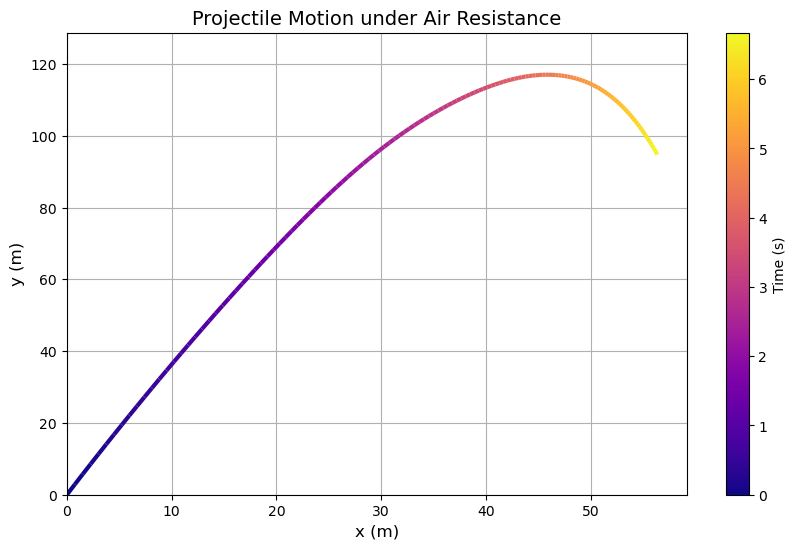

In [ ]:
# Example user-defined inputs
v0 = 60       # Initial speed in m/s
theta = 75     # Launch angle in degrees
mass = 1.0       # Mass in kg
drag = 0.2    # Drag coefficient

# Convert angle to radians

theta_tensor = torch.tensor([[math.radians(theta)]], dtype=torch.float32).to(device)
# Call the prediction function
vx, vy, t_vals = predict_trajectory(
    model=model,
    v0=v0,
    theta=theta_tensor,
    mass=mass,
    drag=drag,
    dt=0.05,
    device=device
)

# Plot trajectory
x, y, t_used = plot_trajectory(vx, vy, t_vals, dt=0.05)
